In [1]:
import glob
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

from Modules import map_to_embeddings
from Modules import generate_figures

In [2]:
def get_shifts(number):
    space = .9 / number
    width = 2 * space / 3
    right = (.9 - space) / 2
    left = -right
    
    shifts = np.linspace(left, right, number)
    
    return width, shifts

In [3]:
def add_ordering_legends(ax, column=['Morph-PV-types'], labels=[], marker='o', legend_args={}):
    ax.set_xticks([]), ax.set_yticks([])
    
    fname = 'Datasets/Lab_Pvalb-transcriptional_labels.tsv'
    df = pd.read_csv(fname, sep='\t', header=0, index_col=0)
    df = df.loc[df.Age>20]
    if len(labels) == 0:
        labels = np.unique(df[column])
    
    fname = 'References/marker_ref.txt'
    df_marker = pd.read_csv(fname, sep='\t', header=0, index_col=0)
    
    colors = df_marker.loc[labels, 'Face'].values
    
    args = ([0], [0])
    kwargs = {'marker':marker, 'markeredgewidth':.25, 'markersize':4, 'color':'w'}
    patches = [Line2D(*args, label=label,
                      markerfacecolor=df_marker.loc[label, 'Face'],
                      markeredgecolor=df_marker.loc[label, 'Edge'],
                      **kwargs
                     ) for label in labels]
    
    kwargs = {'fontsize':6,
              'ncol':5,
              'loc':'upper center',
              'columnspacing':.9,
              'handletextpad':.5
             }
    kwargs.update(legend_args)
    legend = ax.legend(patches, labels, **kwargs)
    
    return

def do_figure_2a(ax, label='MorphType', rectangle=False):
    image = plt.imread('Figures/Image 2.jpg')
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_title('Trans. nbt-SNE', fontsize=7.5)
    ax.imshow(image)
    
    fname = 'Datasets/Lab_Pvalb-transcriptional_labels.tsv'
    df = pd.read_csv(fname, sep='\t', header=0, index_col=0)
    df = df.loc[df.Age>20]
    labels = ['vAAC', 'hBIC', 'hBC', 'vBIC', 'vBC']
    
    fname = 'References/marker_ref.txt'
    df_marker = pd.read_csv(fname, sep='\t', header=0, index_col=0)
    
    return

def add_patches(ax, celltypes, orientation='vertical'):
    
    assert orientation in ('vertical', 'horizontal')
    
    # set up axes
    ax.set_xticks([])
    ax.set_yticks([])
    if orientation == 'horizontal':
        ax.axis([0,len(celltypes),0,1])
    else:
        ax.axis([0,1,0,len(celltypes)])
    
    # get colors
    fname = 'References/marker_ref.txt'
    df_marker = pd.read_csv(fname, sep='\t', header=0, index_col=0)
    facecolors = df_marker.loc[celltypes, 'Face']
    edgecolors = df_marker.loc[celltypes, 'Edge']
    
    # create patches
    if orientation == 'horizontal':
        boxes = [Rectangle((xval,0), 1, 1) for xval in range(len(celltypes))]
    else:
        boxes = [Rectangle((0,yval), 1, 1) for yval in range(len(celltypes))]
    pc = PatchCollection(boxes, facecolors=facecolors, edgecolors=None, alpha=1, linewidth=0)
    ax.add_collection(pc)
    
    return

def do_figure_2b(ax, ax_pro, ax_morph):
    # get similarity matrix between morphological types and prommt types
    df_labels = pd.read_csv('Datasets/Lab_Pvalb-transcriptional_labels.tsv', sep='\t', header=0, index_col=0)
    df_labels = df_labels.loc[df_labels.Age>20]
    celltypes = ['vAAC', 'vBIC', 'hBIC', 'vBC', 'hBC'][::-1]
    protypes = np.unique(df_labels['proMMT-PV-types'])
    
    df_sim = pd.DataFrame(0,index=celltypes,columns=protypes)
    
    for celltype in celltypes:
        is_cell = df_labels['Morph-PV-types'] == celltype
        for protype in protypes:
            is_pro = df_labels['proMMT-PV-types'] == protype
            df_sim.loc[celltype,protype] = np.logical_and(is_cell, is_pro).sum()
    
    # plot similarity data
    # since python's table plot doesn't look very nice, due it in custom mode
    kwargs = {'ha':'center', 'va':'center', 'fontsize':8}
    for yval, celltype in enumerate(celltypes):
        for xval, protype in enumerate(protypes):
            ax.text(xval+.5, yval+.5, df_sim.loc[celltype, protype], **kwargs)
    
    # adjust axes
    cell_count = len(celltypes)
    pro_count = len(protypes)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis([0, pro_count, 0, cell_count])
    
    # draw lines between numbers to mark boxes
    kwargs = {'linewidth':1, 'color':'gray'}
    for xval in range(pro_count):
        ax.plot([xval, xval], [0, cell_count], **kwargs)
    for yval in range(cell_count):
        ax.plot([0, pro_count], [yval, yval], **kwargs)
        
    add_patches(ax_pro, protypes, orientation='horizontal')
    add_patches(ax_morph, celltypes, orientation='vertical')
    
    return

def get_diff_genes():
    fname = 'Differential/edgeR/proMMT'
    files = glob.glob('%s/* vs *.txt' % fname)
    
    fdrs = []
    for fname in files:
        df = pd.read_csv(fname, sep='\t', header=0, index_col=0)
        df = df.loc[np.abs(df.logFC)>1]
        df = df.loc[df.PValue<0.05]
        
        fdrs.append(df.FDR)
    
    df = pd.concat(fdrs, axis=1, join='outer', sort=False)
    df['Lowest'] = df.min(axis=1)
    df.sort_values('Lowest', inplace=True)
    
    df = df.loc[df.Lowest<0.05]
    
    return df.index.tolist()

def get_figure_2c_data():
    df = pd.read_csv('Datasets/Lab_Pvalb-tpm.tsv', sep='\t', header=0, index_col=0)

    df_labels = pd.read_csv('Datasets/Lab_Pvalb-transcriptional_labels.tsv', sep='\t', header=0, index_col=0)
    df_labels = df_labels[df_labels.Age>21]
    
    genes = get_diff_genes()
    df = np.log2(1+df.loc[genes,df_labels.index])
    df.columns = df_labels['proMMT-PV-types']
    
    return df

def add_patches(ax, celltypes, orientation='vertical'):
    
    assert orientation in ('vertical', 'horizontal')
    
    # set up axes
    ax.set_xticks([])
    ax.set_yticks([])
    if orientation == 'horizontal':
        ax.axis([0,len(celltypes),0,1])
    else:
        ax.axis([0,1,0,len(celltypes)])
    
    # get colors
    fname = 'References/marker_ref.txt'
    df_marker = pd.read_csv(fname, sep='\t', header=0, index_col=0)
    facecolors = df_marker.loc[celltypes, 'Face']
    
    # create patches
    if orientation == 'horizontal':
        boxes = [Rectangle((xval,0), 1, 1) for xval in range(len(celltypes))]
    else:
        boxes = [Rectangle((0,yval), 1, 1) for yval in range(len(celltypes))]
    pc = PatchCollection(boxes, facecolors=facecolors, edgecolors=None, linewidth=0)
    ax.add_collection(pc)
    
    return

def do_figure_2c(fig, axrange):
    df = get_figure_2c_data()
    
    celltypes = np.unique(df.columns)
    counts = [(df.columns==celltype).sum() for celltype in celltypes]
    Left, Bottom, Width, Height = axrange
    dW = 0.005
    W = (Width - dW*(len(celltypes)-1)) / sum(counts)
    
    high = df.values.max()
    fname = 'References/marker_ref.txt'
    df_marker = pd.read_csv(fname, sep='\t', header=0, index_col=0)
    
    text_args = {'ha':'center', 'va':'top', 'fontsize':7.5}
    fig.text(Left + Width/2, Bottom+Height+0.016, 'Differentially expressed genes', **text_args)
    
    for col, celltype in enumerate(celltypes):
        color = df_marker.loc[celltype, 'Face']
        df_cell = df[[celltype]]
        count = df_cell.shape[1]
        width = count * W
        ax = fig.add_axes([Left, Bottom, width, Height])
        
        if col == 0:
            ax.set_yticks(np.arange(df.shape[1])+.5)
            ax.set_yticklabels(df.index.tolist())
            ax.tick_params(size=1, labelsize=6, pad=1)
        else:
            ax.set_yticks([])
        ax.set_xticks([])
        ax.axis([0,df_cell.shape[1],df_cell.shape[0],0])
        
        ax.pcolor(df_cell.values, vmin=0, vmax=high, cmap=cm.Reds)
        
        ax_label = fig.add_axes([Left, Bottom-0.01, width, 0.008])
        ax_label.set_xticks([])
        ax_label.set_yticks([])
        ax_label.axis([0,1,0,1])
        
        boxes = [Rectangle((0,0), 1, 1)]
        pc = PatchCollection(boxes, facecolors=color, edgecolors=None, linewidth=0)
        ax_label.add_collection(pc)
        
        Left += dW + width
    
    return

def do_figure_2d(ax):
    
    kwargs = {'filename':'Harris_Genes',
              'label':'Morph-PV-types',
              'age_cutoff':20,
              'map_targets':[],
              'legend_order':['vAAC', 'vBIC', 'hBIC', 'vBC', 'hBC'],
              'plot_order':['vBC', 'hBC', 'vBIC', 'hBIC', 'vAAC'],
              'legend':True
             }
    map_to_embeddings.map_lin_to_harris(ax, **kwargs)
    
    return

def do_figure_2e(ax):
    
    # get data
    fname = 'Mapping/Excel/Map_to_Cell_Types.xlsx'
    df = pd.read_excel(fname, sheet_name='Cell Mappings (knn = 25)', index_col=[0,1]).fillna(0).astype(int)
    
    fname = 'Datasets/Lab_Pvalb-labels.tsv'
    df_labels = pd.read_csv(fname, sep='\t', header=0, index_col=0)
    df_labels = df_labels.loc[df_labels.Age>20]
    df = df.loc[df.index.get_level_values('Cell').isin(df_labels.index)]
    
    df = pd.concat([data.value_counts() for col, data in df.iteritems()], axis=1, join='outer').fillna(0).astype(int)
    df.index = df.index.map({2:'Pvalb.Tac1', 3:'Pvalb.C1ql1'}).fillna('Other')
    df_counts = df.groupby(df.index).sum().loc[['Pvalb.Tac1', 'Pvalb.C1ql1', 'Other']]
    
    df_counts = df_counts / df_counts.sum(axis=0) * 100
    columns = ['Chi_Squared',
               'Correlation',
               'F_Classif',
               'Harris_Genes',
               'Mutual_Info',
               'PV_Pvalb_Kobak_Lin'
              ]
    column_names = ['Chi-squared',
                    'Correlation',
                    'F-classification',
                    'Harris et al.',
                    'Mutual information',
                    'Kobak on Pvalb'
                   ]
    colors = ['#FFFFFF',
              '#CCCCCC',
              '#999999',
              '#666666',
              '#333333',
              '#000000'
             ]
    df_counts = df_counts.loc[:,columns].copy()
    df_counts.columns=column_names
    
    # set up axes
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(labelsize=6, pad=1)
    ax.set_ylabel('Fraction of cells mapped (%)', fontsize=7, labelpad=1)
    ax.set_title('Transcriptome-based mapping', fontsize=8)
    ax.axis([0,3,0,100])
    xvals = np.array([.5,1.5,2.5])
    ax.set_xticks(xvals)
    ax.set_xticklabels(df_counts.index.tolist())
    
    # plot data
    width, shifts = get_shifts(len(columns))
    
    for column, color, shift in zip(column_names, colors, shifts):
        data = df_counts[column]
        ax.bar(xvals+shift, data, facecolor=color, edgecolor='black', linewidth=.2, label=column, width=width)
    
    ax.legend(fontsize=5, frameon=False, loc='upper center', bbox_to_anchor=(0.6,.99))
    ax.text(0.6, 1.02, 'Gene selection methods:', fontsize=6, ha='center', va='top', transform=ax.transAxes)
    
    return

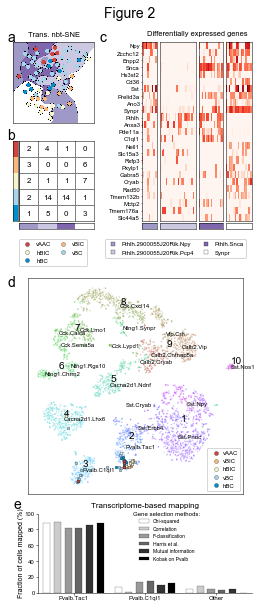

In [4]:
fig, axes = generate_figures.generate_figure_02()

do_figure_2a(axes['A'], label='MorphType')
celltype_order = ['vAAC', 'hBIC', 'hBC', 'vBIC', 'vBC']
add_ordering_legends(axes['Morph_legend'], column='Morph-PV-types', labels=celltype_order, legend_args={'ncol':2})
add_ordering_legends(axes['proMMT_legend'], column='proMMT-PV-types', marker='s', legend_args={'ncol':2})
do_figure_2b(axes['B'], axes['B_xlabel'], axes['B_ylabel'])
do_figure_2c(fig, axes['C_range'])
do_figure_2d(axes['D'])
do_figure_2e(axes['E'])

fig.savefig('Figures/Figure 2.pdf', dpi=500)